<a href="https://colab.research.google.com/github/chaudha4/ML-Jupyter_Notebook/blob/master/Neural%20Network%20-%2003%20Linear%20Regression%20-%20Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Core Learning Algorithms - Linear Regression

We will do Linear regression using Keras since its APIs are much better than Tensorflow APIs.

At a high level we have following steps

1. Prepare training data for model. The data needs to be numeric, so all categorical information needs to be converted to numeric values. Then those values need to be normalized so that they all have similar range. There are two ways to do that.<br><br>
    1. ***Normalize it before feeding the data to a model.***
    1. ***Use Normalization layer as the first layer in the model. We do this.***

1. Create a model. We will use Normalization layer as the first laer since our input data is not normalized. We then use a dense layer, with unit=1. Unit defines the output shape i.e. the shape of the tensor that is produced by the layer. It is 1 in this case since we expect a True(survived) or False.

1. Compile the model. We use adam as an optimization algorithm during compile. In practice, Adam is currently recommended as the default algorithm to use for deep learning models.

1. Train the model (using fit method). Fit() trains the model for a fixed number of epochs (iterations on a dataset) and returns a History callback, which has a history attribute containing the lists of successive losses and other metrics.

1. Now we run test data on the model and see what model predicts. Make sure that your test data is also prepared exactly the same way as train data and all categorical information has been converted to numeric data using same rules.



In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)


In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)


2.4.0


## Training Data
We now prepare data for taring purpose. The data needs to be modified with all text values mapped to numeric values etc.

In [4]:
raw_dataset = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
raw_dataset.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [5]:
train_data = raw_dataset.copy()
train_data.tail()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
622,0,male,28.0,0,0,10.50,Second,unknown,Southampton,y
623,0,male,25.0,0,0,7.05,Third,unknown,Southampton,y
624,1,female,19.0,0,0,30.00,First,B,Southampton,y
625,0,female,28.0,1,2,23.45,Third,unknown,Southampton,n
626,0,male,32.0,0,0,7.75,Third,unknown,Queenstown,y


In [6]:
# Check the data types. Anything that is not numeric will need to be converted.
train_data.dtypes

survived                int64
sex                    object
age                   float64
n_siblings_spouses      int64
parch                   int64
fare                  float64
class                  object
deck                   object
embark_town            object
alone                  object
dtype: object

### Clean Training Data

Clean up invalid data.

In [7]:
# Check if any data is na
train_data.isna().sum()

survived              0
sex                   0
age                   0
n_siblings_spouses    0
parch                 0
fare                  0
class                 0
deck                  0
embark_town           0
alone                 0
dtype: int64

In [8]:
train_data = train_data.dropna()
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
survived,627.0,0.387560,0.487582,0.00,0.0000,0.0000,1.0000,1.0000
age,627.0,29.631308,12.511818,0.75,23.0000,28.0000,35.0000,80.0000
n_siblings_spouses,627.0,0.545455,1.151090,0.00,0.0000,0.0000,1.0000,8.0000
parch,627.0,0.379585,0.792999,0.00,0.0000,0.0000,0.0000,5.0000
fare,627.0,34.385399,54.597730,0.00,7.8958,15.0458,31.3875,512.3292


In [19]:
train_data.shape

(627, 10)

In [31]:
train_data.sex[:4]

0    2
1    1
2    1
3    1
Name: sex, dtype: int64

### Convert to Numeric

Lets convert the non numeric data into a numeric data since the model expects everything to be numeric.

In [9]:
CATEGORICAL_COLUMNS = ['sex', 'class', 'deck', 'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare', 'n_siblings_spouses', 'parch',]

In [10]:
# Find all unique values and map them to numeric values.

temp_data = train_data.copy() # make a deep copy. Not needed but just in case.
cat2num = {}
for cc in CATEGORICAL_COLUMNS:
    kv = {} # e.g {"male":1}
    ii = 1
    for unq in temp_data.sort_values(cc)[cc].unique(): # First Sort, then get unique values
        kv[unq] = ii
        ii += 1
    cat2num[cc] = kv

print(cat2num)

{'sex': {'female': 1, 'male': 2}, 'class': {'First': 1, 'Second': 2, 'Third': 3}, 'deck': {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'unknown': 8}, 'embark_town': {'Cherbourg': 1, 'Queenstown': 2, 'Southampton': 3, 'unknown': 4}, 'alone': {'n': 1, 'y': 2}}


In [11]:
print(temp_data['class'].value_counts())
print(temp_data['deck'].value_counts())
print(temp_data['embark_town'].value_counts())
print(temp_data['alone'].value_counts())


Third     341
First     159
Second    127
Name: class, dtype: int64
unknown    481
C           43
B           37
E           23
D           22
A           11
F            6
G            4
Name: deck, dtype: int64
Southampton    450
Cherbourg      123
Queenstown      53
unknown          1
Name: embark_town, dtype: int64
y    372
n    255
Name: alone, dtype: int64


In [12]:
print("Before: ", train_data.head())

# Use replace to do the conversion to numeric.
train_data.replace(cat2num, inplace=True)

print("After: ", train_data.head())



Before:     survived     sex   age  ...     deck  embark_town  alone
0         0    male  22.0  ...  unknown  Southampton      n
1         1  female  38.0  ...        C    Cherbourg      n
2         1  female  26.0  ...  unknown  Southampton      y
3         1  female  35.0  ...        C  Southampton      n
4         0    male  28.0  ...  unknown   Queenstown      y

[5 rows x 10 columns]
After:     survived  sex   age  n_siblings_spouses  ...  class  deck  embark_town  alone
0         0    2  22.0                   1  ...      3     8            3      1
1         1    1  38.0                   1  ...      1     3            1      1
2         1    1  26.0                   0  ...      3     8            3      2
3         1    1  35.0                   1  ...      1     3            3      1
4         0    2  28.0                   0  ...      3     8            2      2

[5 rows x 10 columns]


In [13]:
# Lets check the data types after conversion
train_data.dtypes

survived                int64
sex                     int64
age                   float64
n_siblings_spouses      int64
parch                   int64
fare                  float64
class                   int64
deck                    int64
embark_town             int64
alone                   int64
dtype: object

In [14]:
train_data.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
survived,627.0,0.387560,0.487582,0.00,0.0000,0.0000,1.0000,1.0000
sex,627.0,1.653907,0.476103,1.00,1.0000,2.0000,2.0000,2.0000
age,627.0,29.631308,12.511818,0.75,23.0000,28.0000,35.0000,80.0000
n_siblings_spouses,627.0,0.545455,1.151090,0.00,0.0000,0.0000,1.0000,8.0000
parch,627.0,0.379585,0.792999,0.00,0.0000,0.0000,0.0000,5.0000
fare,627.0,34.385399,54.597730,0.00,7.8958,15.0458,31.3875,512.3292
class,627.0,2.290271,0.845181,1.00,1.0000,3.0000,3.0000,3.0000
deck,627.0,6.904306,2.107441,1.00,8.0000,8.0000,8.0000,8.0000
embark_town,627.0,2.524721,0.803712,1.00,2.0000,3.0000,3.0000,4.0000
alone,627.0,1.593301,0.491610,1.00,1.0000,2.0000,2.0000,2.0000


### Inspect the data


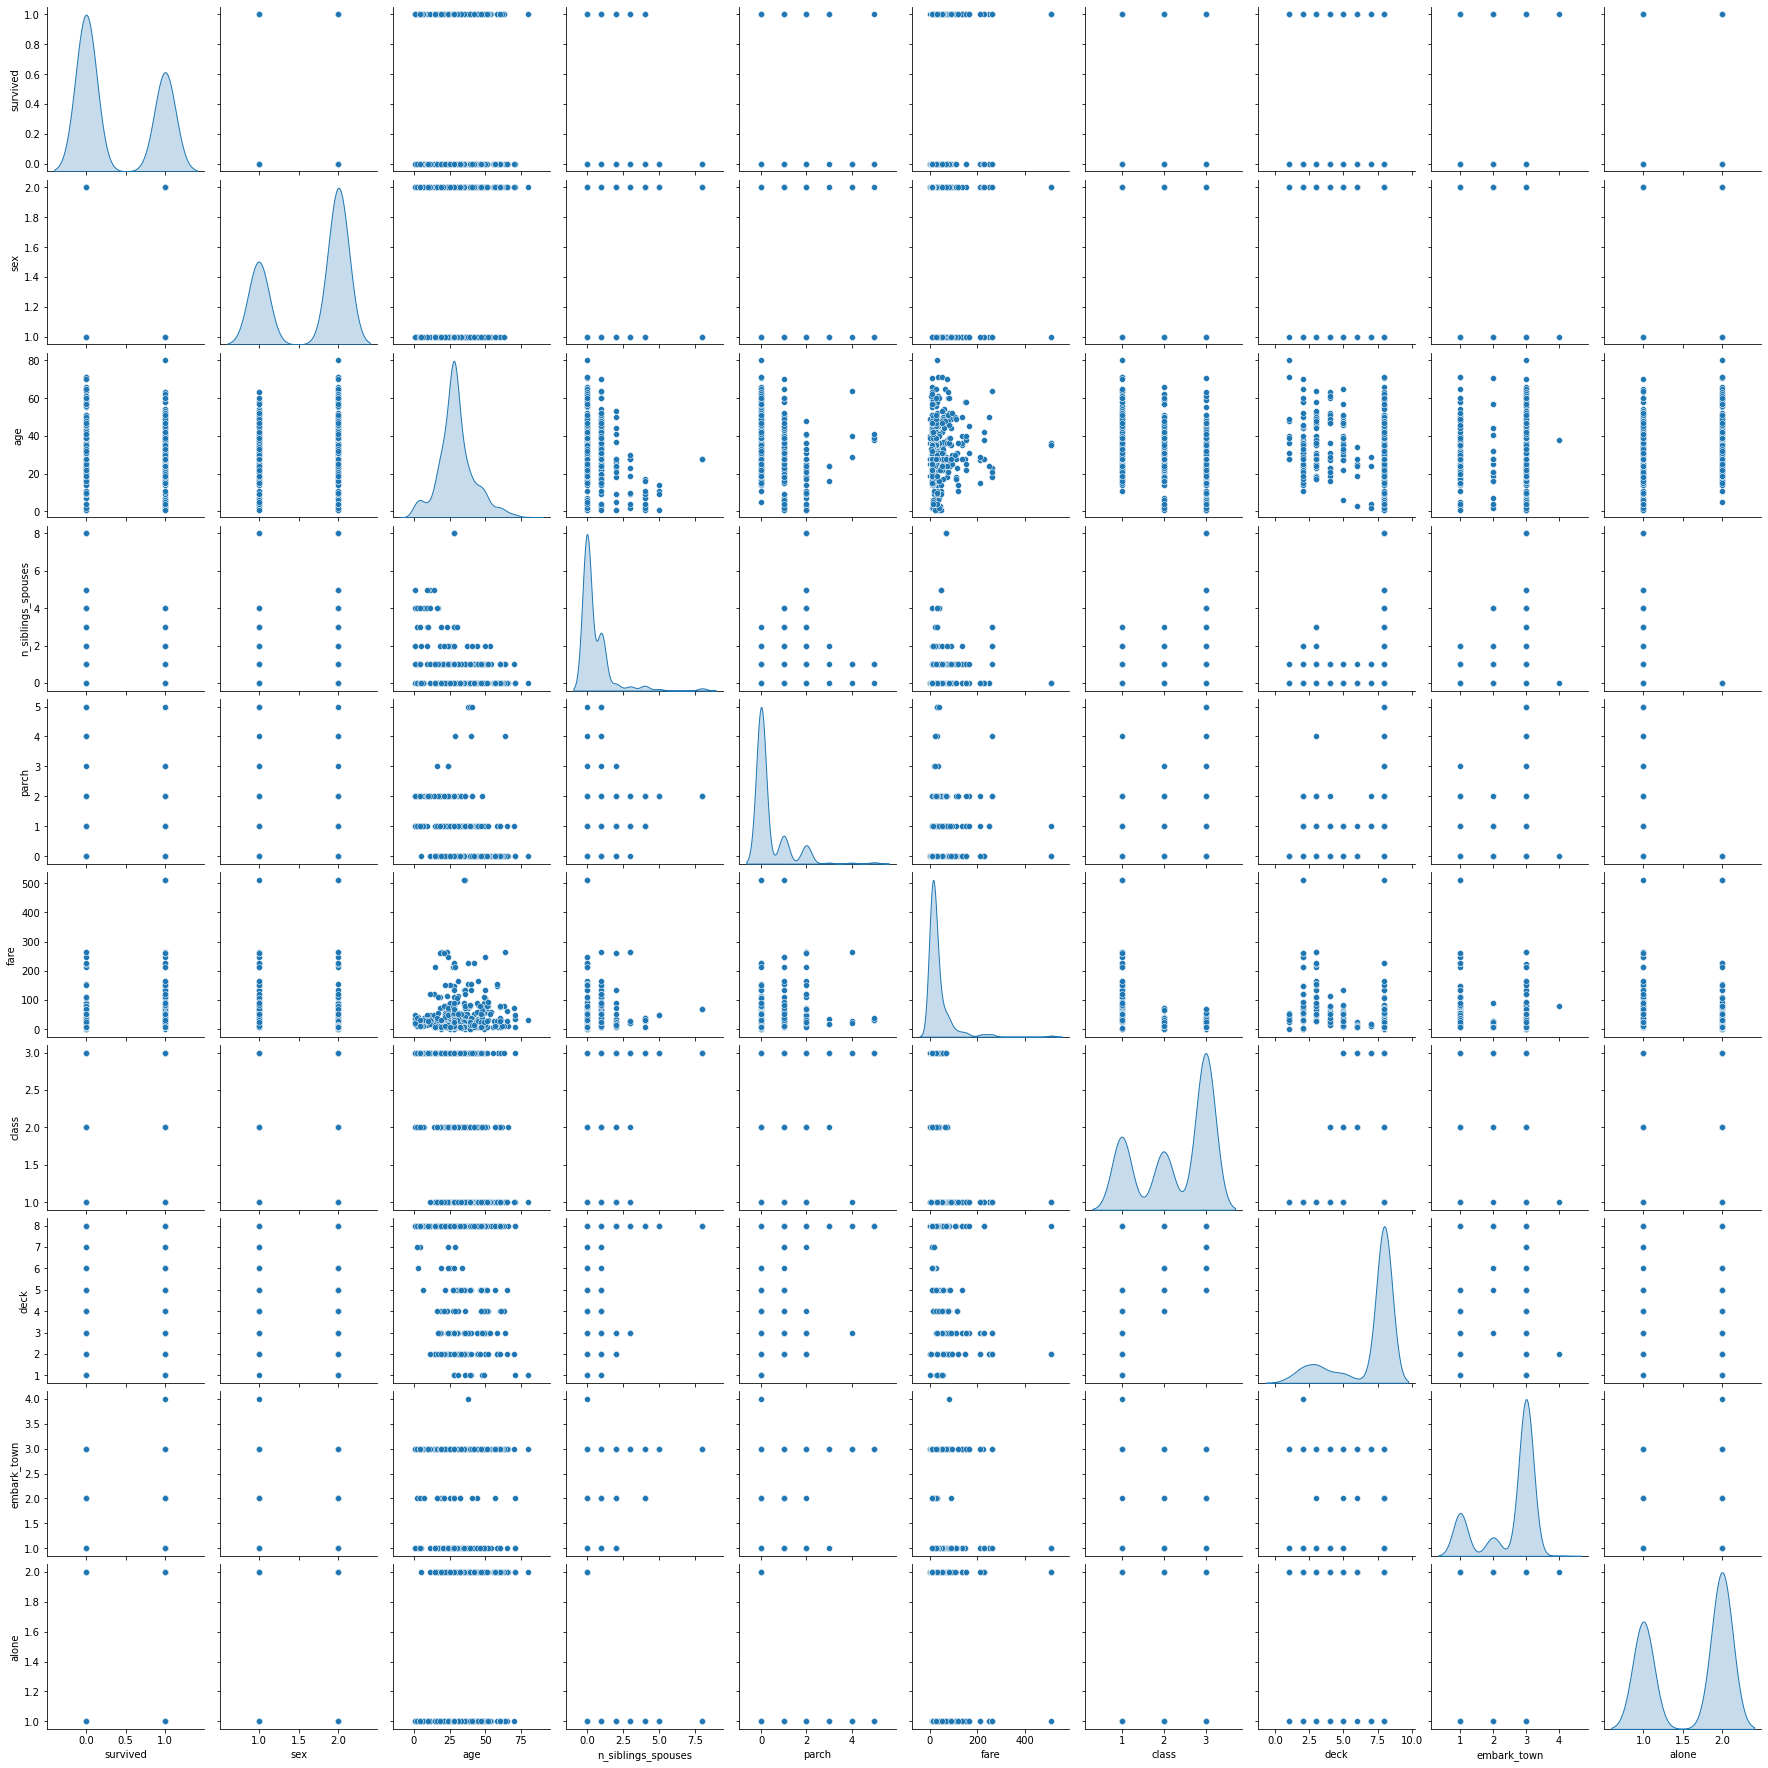

In [34]:
#Plot pairwise relationships in a dataset.

sns.pairplot(train_data, diag_kind='kde')
#sns.pairplot(train_data, diag_kind='kde')
#sns.pairplot(train_data[['survived','sex']], diag_kind='hist', height=2.5)
#sns.pairplot(train_data[['survived','sex']], diag_kind='kde', height=2.5)

### Split features from labels

Separate the target value, the "survived", from the features. This label, "survived" is the value that we will train the model to predict.

In [43]:
train_features = train_data.copy()
train_labels = train_features.pop('survived')

train_labels.tail()

622    0
623    0
624    1
625    0
626    0
Name: survived, dtype: int64

## Prepare Test Data

In [44]:
raw_td = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data
raw_td.tail()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
259,1,female,25.0,0,1,26.0000,Second,unknown,Southampton,n
260,0,male,33.0,0,0,7.8958,Third,unknown,Southampton,y
261,0,female,39.0,0,5,29.1250,Third,unknown,Queenstown,n
262,0,male,27.0,0,0,13.0000,Second,unknown,Southampton,y
263,1,male,26.0,0,0,30.0000,First,C,Cherbourg,y


In [45]:
td = raw_td.copy() # make a deep copy

In [46]:
td.replace(cat2num, inplace=True)
td.tail()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
259,1,1,25.0,0,1,26.0000,2,8,3,1
260,0,2,33.0,0,0,7.8958,3,8,3,2
261,0,1,39.0,0,5,29.1250,3,8,2,1
262,0,2,27.0,0,0,13.0000,2,8,3,2
263,1,2,26.0,0,0,30.0000,1,3,1,2


In [47]:
# Prepare test data and test label
test_features = td.copy()
test_features.head()


,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,2,35.0,0,0,8.0500,3,8,3,2
1,0,2,54.0,0,0,51.8625,1,5,3,2
2,1,1,58.0,0,0,26.5500,1,3,3,2
3,1,1,55.0,0,0,16.0000,2,8,3,2
4,1,2,34.0,0,0,13.0000,2,4,3,2


In [48]:
test_labels = td.pop('survived')
test_features.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,2,35.0,0,0,8.0500,3,8,3,2
1,0,2,54.0,0,0,51.8625,1,5,3,2
2,1,1,58.0,0,0,26.5500,1,3,3,2
3,1,1,55.0,0,0,16.0000,2,8,3,2
4,1,2,34.0,0,0,13.0000,2,4,3,2


In [49]:
td.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,2,35.0,0,0,8.0500,3,8,3,2
1,2,54.0,0,0,51.8625,1,5,3,2
2,1,58.0,0,0,26.5500,1,3,3,2
3,1,55.0,0,0,16.0000,2,8,3,2
4,2,34.0,0,0,13.0000,2,4,3,2


In [50]:
test_labels.tail()

259    1
260    0
261    0
262    0
263    1
Name: survived, dtype: int64

## Creating the model (single-variable linear regression)

Now, we create a model that makes predictions based on single input. We could predict the survival based on age (And ignore all other data). This model will not be very accurate for obvious reasons!!

### Normalize Data
It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model might converge without feature normalization, normalization makes training much more stable.

The ```preprocessing.Normalization``` layer is a clean and simple way to build that preprocessing into your model.

In [51]:
age = np.array(train_features['age'])
age[-5:]

array([28., 25., 19., 28., 32.])

In [52]:
age_normalizer = preprocessing.Normalization(input_shape=[1,])
age_normalizer.adapt(age)

In [ ]:
print(age_normalizer.mean.numpy())

### Build Sequential Model

In [53]:
age_model = tf.keras.Sequential([
    age_normalizer,
    layers.Dense(units=1)
])

age_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


### Compile Model

In [54]:
age_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


### Train Model

In [55]:
%%time
history = age_model.fit(
    train_features['age'], train_labels,
    epochs=100,
    # suppress logging
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)


Epoch 1/100
16/16 [==============================] - 1s 16ms/step - loss: 0.9850 - val_loss: 0.4466
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.4633 - val_loss: 0.3879
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4134 - val_loss: 0.3506
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4059 - val_loss: 0.3609
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4007 - val_loss: 0.3471
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 0.4161 - val_loss: 0.3548
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4069 - val_loss: 0.3420
Epoch 8/100
16/16 [==============================] - 0s 5ms/step - loss: 0.4164 - val_loss: 0.3544
Epoch 9/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4194 - val_loss: 0.3436
Epoch 10/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4169 - val_loss: 0.3522
Epoch 11

In [56]:
# Visualize the model's training progress using the stats stored in the history object.
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,loss,val_loss,epoch
95,0.408298,0.350477,95
96,0.404626,0.356750,96
97,0.409869,0.351058,97
98,0.406423,0.345317,98
99,0.408753,0.351668,99


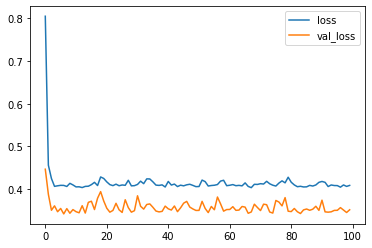

In [57]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()


### Evaluate the Model

In [58]:

test_results = age_model.evaluate(
    test_features['age'],
    test_labels, verbose=1)


9/9 [==============================] - 0s 1ms/step - loss: 0.3863


In [59]:
# See if our model predicts accurately with training data ?
age_model.predict(train_features['age'][:5])

array([[0.01 ],
       [0.042],
       [0.018],
       [0.036],
       [0.022]], dtype=float32)

### Predict using the Model
Since this is a single variable regression it's easy to look at the model's predictions as a function of the input


In [60]:
td1 = raw_td.copy() # deep copy test data
td1 = td1["age"]
td1.head()

0    35.0
1    54.0
2    58.0
3    55.0
4    34.0
Name: age, dtype: float64

In [61]:
predictions = age_model.predict(td1[:1])

In [62]:
print(predictions)

[[0.036]]


In [63]:
count_correct = 0
for p, actual in zip(predictions, test_labels):
    predicted = int(round(p[0])) # p is a numpy array with just one value.
    if (predicted == actual):
        count_correct += 1

print(f'Correctly predicted {count_correct} out of {len(test_labels)}')

Correctly predicted 1 out of 264


In [ ]:
deck = np.array(train_features['class'])
deck[-5:]

array([2, 3, 1, 3, 3])

In [ ]:
#deck_normalizer = preprocessing.Normalization(input_shape=[1,])
deck_normalizer = preprocessing.Normalization()
deck_normalizer.adapt(deck)

In [ ]:
print(deck_normalizer.mean.numpy())


[2.29]


In [ ]:
deck_model = tf.keras.Sequential([
    deck_normalizer,
    layers.Dense(units=1)
])

deck_model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_4 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [ ]:
td2 = train_data.copy() # deep copy test data
td2 = td2["class"]
td2.head()

0    3
1    1
2    3
3    1
4    3
Name: class, dtype: int64

In [ ]:
predictions = age_model.predict(td2[:6])

In [ ]:
print(predictions)

[[-0.054]
 [-0.06 ]
 [-0.054]
 [-0.06 ]
 [-0.054]
 [-0.054]]


In [ ]:
count_correct = 0
for p, actual in zip(predictions, test_labels):
    predicted = int(round(p[0])) # p is a numpy array with just one value.
    if (predicted == actual):
        count_correct += 1

print(f'Correctly predicted {count_correct} out of {len(test_labels)}')

Correctly predicted 2 out of 264


## Creating the model (multi-variable linear regression)

Now, we create a model that makes predictions based on multiple inputs.

### Normalize Data
It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model might converge without feature normalization, normalization makes training much more stable.

The ```preprocessing.Normalization``` layer is a clean and simple way to build that preprocessing into your model.

In [64]:
# The first step is to create the layer
normalizer = preprocessing.Normalization()


In [65]:
train_features

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,2,22.0,1,0,7.2500,3,8,3,1
1,1,38.0,1,0,71.2833,1,3,1,1
2,1,26.0,0,0,7.9250,3,8,3,2
3,1,35.0,1,0,53.1000,1,3,3,1
4,2,28.0,0,0,8.4583,3,8,2,2
...,...,...,...,...,...,...,...,...,...
622,2,28.0,0,0,10.5000,2,8,3,2
623,2,25.0,0,0,7.0500,3,8,3,2
624,1,19.0,0,0,30.0000,1,2,3,2
625,1,28.0,1,2,23.4500,3,8,3,1


In [66]:
# Then adapt() it to the data
normalizer.adapt(np.array(train_features))


In [67]:
# This calculates the mean and variance, and stores them in the layer. 
print(normalizer.mean.numpy())


[ 1.654 29.631  0.545  0.38  34.385  2.29   6.904  2.525  1.593]


In [68]:
# When the layer is called it returns the input data, with each feature independently normalized
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())


First example: [[ 2.   22.    1.    0.    7.25  3.    8.    3.    1.  ]]

Normalized: [[ 0.73 -0.61  0.4  -0.48 -0.5   0.84  0.52  0.59 -1.21]]


### Create Model

In [69]:

linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 9)                 19        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10        
Total params: 29
Trainable params: 10
Non-trainable params: 19
_________________________________________________________________


In [70]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


In [71]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)


CPU times: user 8.07 s, sys: 237 ms, total: 8.3 s
Wall time: 7.85 s


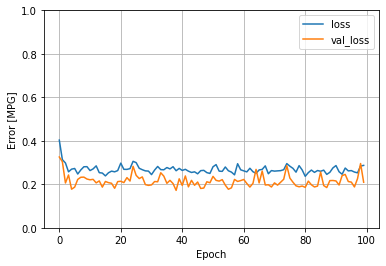

In [72]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)


plot_loss(history)


## Run the model on test data

In [73]:
test_features.tail()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
259,1,1,25.0,0,1,26.0000,2,8,3,1
260,0,2,33.0,0,0,7.8958,3,8,3,2
261,0,1,39.0,0,5,29.1250,3,8,2,1
262,0,2,27.0,0,0,13.0000,2,8,3,2
263,1,2,26.0,0,0,30.0000,1,3,1,2


In [74]:
test_labels.tail()

259    1
260    0
261    0
262    0
263    1
Name: survived, dtype: int64

In [75]:
# Returns the loss value & metrics values for the model in test mode.
test_results = linear_model.evaluate(
    test_features.drop(columns=['survived']), test_labels, verbose=1)


9/9 [==============================] - 0s 1ms/step - loss: 0.3005


In [76]:
print(test_results)

0.30050721764564514


In [77]:
tf1 = test_features.drop(columns=['survived']) # Remove col that would be predicted.

predictions = linear_model.predict(tf1)
print("First 5 predictions: ", predictions[:5])
print("Last 5 predictions: ", predictions[-5:])

First 5 predictions:  [[-0.062]
 [ 0.071]
 [ 1.118]
 [ 1.053]
 [-0.011]]
Last 5 predictions:  [[ 1.003]
 [-0.069]
 [ 1.046]
 [-0.049]
 [ 0.111]]


In [78]:
count_correct = 0
for p, actual in zip(predictions, test_labels):
    predicted = int(round(p[0])) # p is a numpy array with just one value.
    if (predicted == actual):
        count_correct += 1

print(f'Correctly predicted {count_correct} out of {len(test_labels)}')

Correctly predicted 196 out of 264
